In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 30
test_date = 180


In [3]:
### 데이터 로드
data = pd.read_csv('dataset/PM_2.5_dataset_with_china.csv', index_col=0)
data.head()

pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
temprature_data = data['temprature'].values
humidity_data = data['humidity'].values
wind_speed_data = data['max wind speed'].values
wind_direction_data = data['wind direction'].values

In [4]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return temp_data

In [5]:
## 정규화 함수
def normalize_windows(data):
    normalized_data = []
    head = []
    tail = []

    for window in data:
        head.append(window[0])
        tail.append(window[-1])
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data), head, tail

In [6]:
## 전처리함수
def pre_processing(data):
    seq_temp = make_sequential(data)
    pre_result, head, tail = normalize_windows(seq_temp)
    
    return pre_result, head, tail

In [7]:
norm_pm_seoul, head_data, tail_data = pre_processing(pm_seoul_data)
norm_pm_beijing, _, _ = pre_processing(pm_beijing_data)
norm_temprature, _, _ = pre_processing(temprature_data)
norm_humidity, _, _ = pre_processing(humidity_data)
norm_wind_speed, _, _ = pre_processing(wind_speed_data)
norm_wind_direction, _, _ = pre_processing(wind_direction_data)

In [8]:
## 병합함수

def marge_data(a, b, c, d, e, f):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index in zip(a, b, c, d, e, f):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            marge.append(e_index[i])
            marge.append(f_index[i])
            
        for i in range(3):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_temprature, norm_humidity, norm_wind_speed, norm_wind_direction)
print(norm_result[0])

[ 0.          0.          0.          0.          0.04597416 -0.06794021
 -0.17777778 -0.20689655  0.07074221 -0.01945888 -0.13333333 -0.13793103
 -0.08358184 -0.06215446 -0.04444444  0.          0.33842777 -0.22357103
  0.         -0.06896552  1.19483101 -0.22063944 -0.31111111  0.
  0.90047217 -0.15928163 -0.11111111  0.          0.65088635 -0.2274784
 -0.06666667  0.          0.4917992  -0.2962978   0.02222222  0.
  0.23649768 -0.08491173  0.11111111 -0.06896552 -0.05119284 -0.264351
  0.62222222  0.          0.20982439 -0.09472471  0.48888889 -0.06896552
 -0.0273774  -0.02810137 -0.08888889  0.          0.42702121 -0.01346105
  0.31111111  0.         -0.11787608 -0.03739358 -0.15555556 -0.13793103
  0.22982936  0.10157812 -0.28888889 -0.82758621  1.15196322 -0.01731132
 -0.22222222 -0.82758621  1.48156892  0.01541344  0.35555556 -0.06896552
  0.8699884   0.14535096  0.35555556 -0.06896552  0.10884692 -0.32149817
 -0.26666667  0.          0.28317594 -0.36548833  0.08888889 -0.310344

In [9]:
year = 365
train_cut = year * 8 + 1 -30

test_cut = -test_date
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2891, 120, 1) (551, 120, 1) (180, 120, 1)
(2891, 1) (551, 1) (180, 1)


In [10]:
train_1 = norm_pm_seoul[:train_cut, :]
np.random.shuffle(train_1)
valid_1 = norm_pm_seoul[train_cut:test_cut, :]
test_1 = norm_pm_seoul[test_cut:, :]

x_train_1 = train_1[:, :-1]
x_train_1 = np.reshape(x_train_1, (x_train_1.shape[0], x_train_1.shape[1], 1))

x_valid_1 = valid_1[:, :-1]
x_valid_1 = np.reshape(x_valid_1, (x_valid_1.shape[0], x_valid_1.shape[1], 1))

x_test_1 = test_1[:, :-1]
x_test_1 = np.reshape(x_test_1, (x_test_1.shape[0], x_test_1.shape[1], 1))


train_2 = norm_pm_beijing[:train_cut, :]
np.random.shuffle(train_2)
valid_2 = norm_pm_beijing[train_cut:test_cut, :]
test_2 = norm_pm_beijing[test_cut:, :]

x_train_2 = train_2[:, :-1]
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1], 1))

x_valid_2 = valid_2[:, :-1]
x_valid_2 = np.reshape(x_valid_2, (x_valid_2.shape[0], x_valid_2.shape[1], 1))

x_test_2 = test_2[:, :-1]
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], x_test_2.shape[1], 1))

print(x_train_1.shape, x_valid_1.shape, x_test_1.shape)

(2891, 30, 1) (551, 30, 1) (180, 30, 1)


In [ ]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint_archi_5/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

### 학습 모델 로드

model = load_model('model/pm_prediction_model_achi_6.h5')

In [66]:
### VCRNN 모델 설계
model = Sequential()


model.add(Conv1D(150, 2, activation='relu',strides=2, input_shape=(120,1)))
model.add(Conv1D(100, 2, activation='relu',strides=2))
# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))

for i in range (2):
    model.add(LSTM(60, return_sequences=True))
    model.add(Dropout(0.5))

model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 60, 150)           450       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 30, 100)           30100     
_________________________________________________________________
lstm_22 (LSTM)               (None, 30, 60)            38640     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 60)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30, 60)            29040     
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 60)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 30)                10920     
__________

In [31]:
from keras.models import Model
from keras import Input
from keras.layers import concatenate, Flatten

# 서울 미세먼지 lstm
pm_seoul_input = Input(shape=(30,1), dtype='float32', name='pm_seoul')
pm_seoul_lstm1 = LSTM(30, return_sequences=True)(pm_seoul_input)
#pm_seoul_lstm2 = LSTM(30, return_sequences=True)(pm_seoul_lstm1)
#pm_seoul_lstm3 = LSTM(30, return_sequences=True)(pm_seoul_lstm2)

# 중국 미세먼지 lstm
pm_beijing_input = Input(shape=(30,1),dtype='float32', name='pm_beijing')
pm_beijing_lstm1 = LSTM(30, return_sequences=True)(pm_beijing_input)
#pm_beijing_lstm2 = LSTM(30, return_sequences=True)(pm_beijing_lstm1)
#pm_beijing_lstm3 = LSTM(30, return_sequences=True)(pm_beijing_lstm2)

concatenated = concatenate([pm_seoul_lstm1, pm_beijing_lstm1])



conv_layer1 = Conv1D(10, 3, activation='linear', strides=3)(concatenated)


flatten = Flatten()(conv_layer1)



output_layer = Dense(1, activation='linear')(flatten)

model = Model([pm_seoul_input, pm_beijing_input], output_layer)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pm_seoul (InputLayer)           (None, 30, 1)        0                                            
__________________________________________________________________________________________________
pm_beijing (InputLayer)         (None, 30, 1)        0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 30, 30)       3840        pm_seoul[0][0]                   
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 30, 30)       3840        pm_beijing[0][0]                 
__________________________________________________________________________________________________
concatenat

In [ ]:
## 콜백 리스트 - 정해진 에폭동안 모니터링 지표가 향상되지 않으면 훈련을 중지
callback_list = [
    keras.callbacks.EarlyStooping(
        monitor='val_acc', patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/checkpoint/temp_model.h5',
        moitor='val_loss',
        save_best_only=True,
    )
]

In [25]:
## 검증손실이 향상되지 않을때 학습율을 작게함
callback_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, # 콜백 호출시 학습률을 10배로 줄인다.
    patience=10,
    )
]

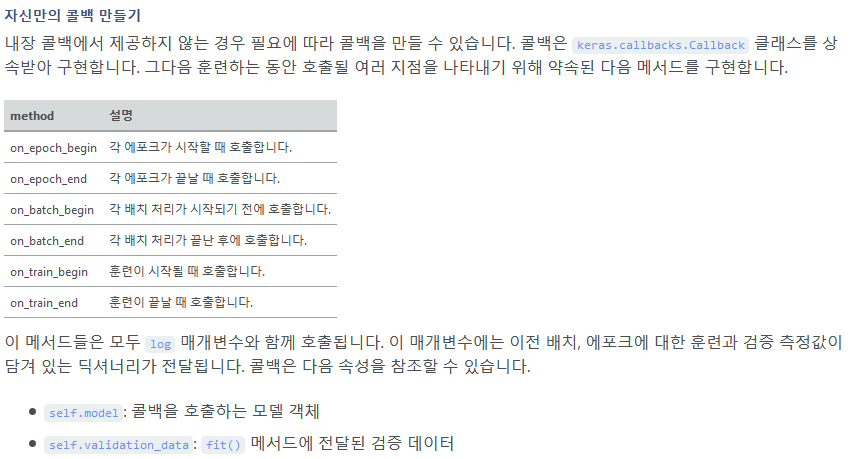

In [32]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

#hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=100)
hist = model.fit({'pm_seoul':x_train_1, 'pm_beijing':x_train_2}, y_train, validation_data=({'pm_seoul':x_valid_1, 'pm_beijing':x_valid_2}, y_valid), epochs=10, batch_size=100)

Train on 2891 samples, validate on 551 samples
Epoch 1/10
2891/2891 [==============================] - 6s 2ms/step - loss: 1.2407 - acc: 0.0000e+00 - val_loss: 0.9255 - val_acc: 0.0000e+00
Epoch 2/10
2891/2891 [==============================] - 3s 897us/step - loss: 1.2266 - acc: 0.0000e+00 - val_loss: 0.9172 - val_acc: 0.0000e+00
Epoch 3/10
2891/2891 [==============================] - 3s 883us/step - loss: 1.2225 - acc: 0.0000e+00 - val_loss: 1.0175 - val_acc: 0.0000e+00
Epoch 4/10
2891/2891 [==============================] - 3s 917us/step - loss: 1.2225 - acc: 0.0000e+00 - val_loss: 0.9254 - val_acc: 0.0000e+00
Epoch 5/10
2891/2891 [==============================] - 3s 896us/step - loss: 1.2214 - acc: 0.0000e+00 - val_loss: 0.9803 - val_acc: 0.0000e+00
Epoch 6/10
2891/2891 [==============================] - 3s 890us/step - loss: 1.2198 - acc: 0.0000e+00 - val_loss: 0.9802 - val_acc: 0.0000e+00
Epoch 7/10
2891/2891 [==============================] - 3s 884us/step - loss: 1.2172 - acc:

In [12]:
## 모델 저장
model.save('model/pm_prediction_model_achi_new.h5')

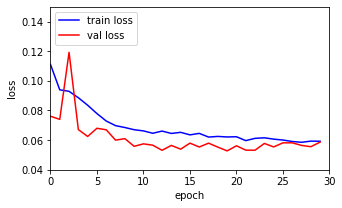

In [29]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.xlim([0, 30])
plt.ylim([0.04, 0.15])

plt.show()

In [28]:
## 결과 실제화 
y_true = tail_data[test_cut:]

y_pred = []

pred = model.predict({'pm_seoul':x_test_1, 'pm_beijing':x_test_2})
test_head_data = head_data[test_cut:]

for i in range(test_date):
    temp = test_head_data[i]*(pred[i]+1)
    y_pred.append(temp.tolist())
    
y_pred = sum(y_pred,[])

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


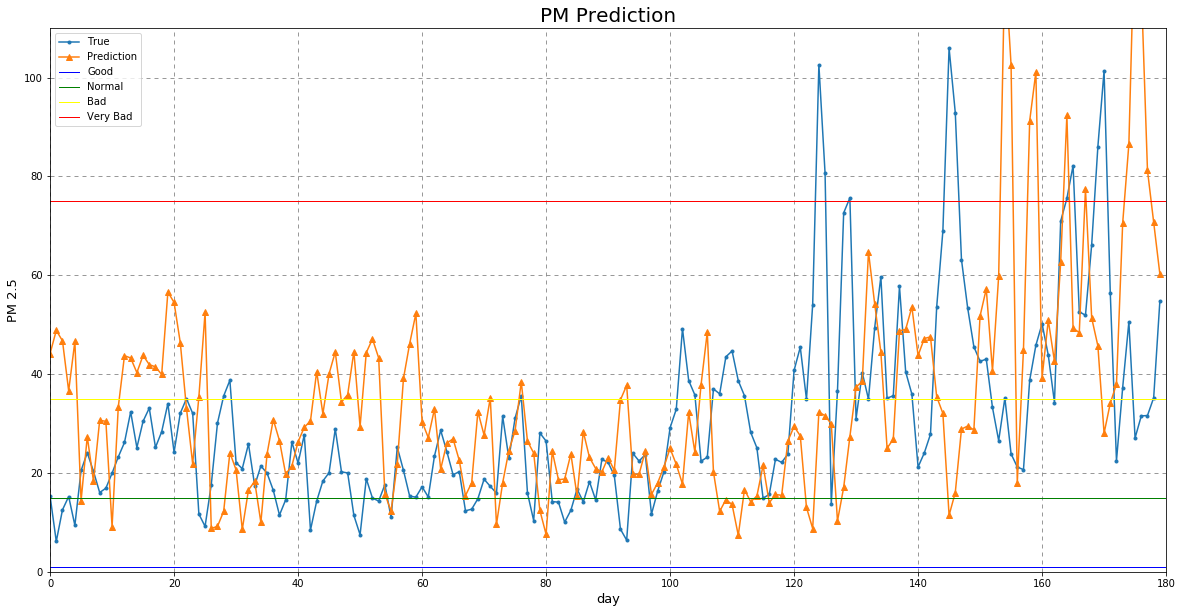

In [29]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=15, color='green', linewidth=1, label='Normal')
plt.axhline(y=35, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=75, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 2.5', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 110])

ax.legend()
plt.show()

In [30]:
## 단계별 정확도 및 총 정확도 계산 함수
def pm_level(pm):
    level_1 = 15
    level_2 = 35
    level_3 = 75
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [17]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [18]:
## 정확도 결과
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.39444444444444443
level 'Good' accuracy: 0.06896551724137931
level 'Normal' accuracy: 0.5263157894736842
level 'Bad' accuracy: 0.40425531914893614
level 'Veray Bad' accuracy: 0.0
